# Analysis of the ARPA for a possible QN

In [3]:
import pandas as pd
import numpy as np
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
import taxcalc as tc
import matplotlib.pyplot as plt

In [4]:
puf_path = (
    "/Users/richardevans/Docs/Economics/OSE/Tax-Calculator/taxcalc/puf.csv"
)
recs = tc.Records(data=puf_path)
pol_base = tc.Policy()
calc_base = tc.Calculator(policy=pol_base, records=recs)
CYR = 2024
calc_base.advance_to_year(CYR)
calc_base.calc_all()
itax_rev_base = calc_base.weighted_total('iitax')

In [ ]:
rec = taxcalc.records.Records(data=puf_path)
tc_base = taxcalc.calculator.Calculator(policy=pol, records=rec)
ref = pol.read_json_reform('../taxcalc/ARPA.json')
pol.implement_reform(ref)
tc_arpa = taxcalc.calculator.Calculator(policy=pol, records=rec)

In [8]:
# Compute annual revenue for each year in a 10 year budget window
# Do this for with and without the ARPA
rev_base = {'IIT': {}, 'Payroll': {}}
rev_arpa = {'IIT': {}, 'Payroll': {}}
for t in range(2024, 2034):
    tc_base.advance_to_year(t)
    tc_base.calc_all()
    tc_arpa.advance_to_year(t)
    tc_arpa.calc_all()
    rev_base['IIT'][t] = tc_base.weighted_total('iitax')
    rev_base['Payroll'][t] = tc_base.weighted_total('payrolltax')
    rev_arpa['IIT'][t] = tc_arpa.weighted_total('iitax')
    rev_arpa['Payroll'][t] = tc_arpa.weighted_total('payrolltax')

In [9]:
# make table of revenue estimates
rev_base_df = pd.DataFrame.from_dict(rev_base).T
rev_arpa_df = pd.DataFrame.from_dict(rev_arpa).T
diff_df = (rev_arpa_df - rev_base_df) * 1e-9
pd.options.display.float_format = '${:.3f}'.format
diff_df['2021-2030'] = diff_df.sum(axis=1)
# print(diff_df.to_latex())
diff_df

,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2021-2030
IIT,$-1.229,$-513.430,$-0.285,$-0.307,$-0.331,$-0.342,$14.878,$-0.369,$-0.376,$-0.383,$-0.394,$-502.568
Payroll,$0.000,$0.000,$0.000,$0.000,$0.000,$0.000,$0.000,$0.000,$0.000,$0.000,$0.000,$0.000


# Distributional results

See below + table by Cody

In [153]:
# Restart calculation to get back to first year
pol = taxcalc.policy.Policy()
tc_base = taxcalc.calculator.Calculator(policy=pol, records=rec)
pol.implement_reform(ref)
tc_arpa = taxcalc.calculator.Calculator(policy=pol, records=rec)
tc_base.advance_to_year(2021)
tc_arpa.advance_to_year(2021)
tc_base.calc_all()
tc_arpa.calc_all()

# get data for plots
mars = 'ALL'
mtr_wrt_full_compen = True
record_variables = ['s006', 'XTOT']
if mars != 'ALL':
    record_variables.append('MARS')
record_variables.append('expanded_income')
record_variables.append('e00200')
vdf = tc_base.dataframe(record_variables)
# create 'tax1' and 'tax2' columns given specified atr_measure
vdf['tax1'] = tc_base.array('iitax')
vdf['tax2'] = tc_arpa.array('iitax')
# compute mtrs for mtr plot data
(mtr1_ptax, mtr1_itax, mtr1_combined) = tc_base.mtr(
    variable_str='e00200p', wrt_full_compensation=mtr_wrt_full_compen)
(mtr2_ptax, mtr2_itax, mtr2_combined) = tc_arpa.mtr(
    variable_str='e00200p', wrt_full_compensation=mtr_wrt_full_compen)
vdf['mtr1'] = mtr1_itax
vdf['mtr2'] = mtr2_itax

mtr_data = taxcalc.calculator.mtr_graph_data(vdf,
                              year=2021,
                              mars=mars,
                              mtr_measure='itax',
                              alt_e00200p_text='This text',
                              mtr_wrt_full_compen=True,
                              income_measure='expanded_income',
                              pop_quantiles=True,
                              dollar_weighting=False)
atr_data = taxcalc.calculator.atr_graph_data(vdf,
                              year=2021,
                              mars=mars,
                              atr_measure='itax',
                              pop_quantiles=True)

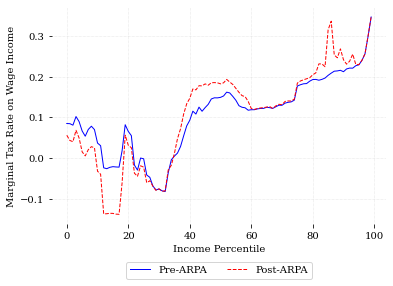

In [150]:
plt.plot(mtr_data['lines'].index, mtr_data['lines'].base.values, label='Pre-ARPA')
plt.plot(mtr_data['lines'].index, mtr_data['lines'].reform.values, label='Post-ARPA')
plt.xlabel('Income Percentile')
plt.ylabel('Marginal Tax Rate on Wage Income')
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.savefig('arpa_mtr_plot.png', bbox_inches='tight')

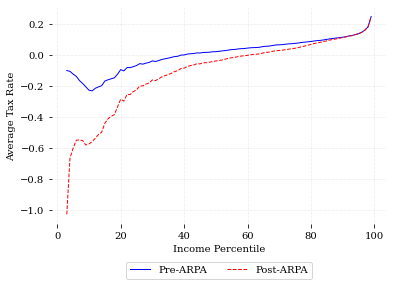

In [151]:
plt.plot(atr_data['lines'].index, atr_data['lines'].base.values, label='Pre-ARPA')
plt.plot(atr_data['lines'].index, atr_data['lines'].reform.values, label='Post-ARPA')
plt.xlabel('Income Percentile')
plt.ylabel('Average Tax Rate')
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.savefig('arpa_atr_plot.png', bbox_inches='tight')

# Tax benefits by family size

In [154]:
df = tc_base.dataframe(['nu18', 'XTOT', 'iitax', 'c00100', 's006', 'aftertax_income', 'expanded_income'])
df['ARPA_iitax'] = tc_arpa.array('iitax')
df['tax_change'] = df['ARPA_iitax'] - df['iitax']
df['aftertax_income_ARPA'] = tc_arpa.array('aftertax_income')
df.groupby('nu18')[['s006', 'XTOT']].sum()

,s006,XTOT
nu18,,
$0.000,$126133140.040,$231598.000
$1.000,$29116910.620,$107256.000
$2.000,$17372053.900,$122138.000
$3.000,$6989282.220,$69597.000
$4.000,$152799.210,$1040.000
$5.000,$19957.650,$92.000
$6.000,$4055.620,$32.000


In [19]:
mdf.weighted_mean(df, 'nu18', 's006')

0.47591657429229645

In [155]:
decile_bounds = np.arange(0, 1.1, 0.1)
deciles = mdf.weighted_quantile(df, 'c00100', 's006', decile_bounds)
quintile_bounds = np.arange(0, 1.2, 0.2)
quintiles = mdf.weighted_quantile(df, 'c00100', 's006', quintile_bounds)

<AxesSubplot:xlabel='nu18'>

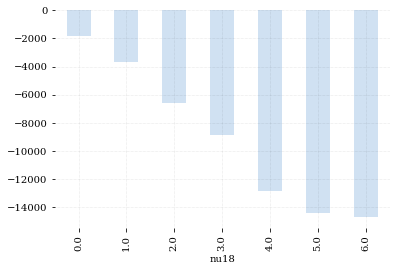

In [129]:
df_group = mdf.weighted_mean(df, 'tax_change', w='s006', groupby=['nu18'])
df_group.plot.bar()

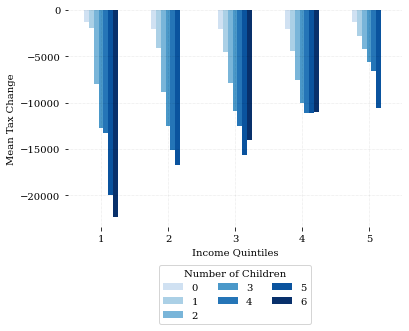

In [156]:
from cycler import cycler
from cycler import cycler
N = 7
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Blues(np.linspace(0.2,1,N)))


df['quintiles'] = pd.cut(df['expanded_income'], bins=quintiles, labels=np.arange(1,6).tolist())
df_group = pd.DataFrame(mdf.weighted_mean(df, 'tax_change', w='s006', groupby=['nu18', 'quintiles']))
# df_group.plot.bar()
df_group.reset_index(inplace=True)
df_group.rename(columns={0: 'Average Change in Taxes', 'nu18': 'Number of Children', 'quintiles': 'Income Quintiles'}, inplace=True)
df_group['Number of Children'] = df_group['Number of Children'].astype('int64')
ax1 = df_group.pivot("Income Quintiles", "Number of Children", "Average Change in Taxes").plot(kind='bar', alpha=1.0)
plt.ylabel('Mean Tax Change')
plt.xticks(rotation = 0)
plt.legend(title='Number of Children', loc=9, bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.savefig('bar_plot_by_kids.png', bbox_inches='tight')

In [157]:
df.drop(df[df['expanded_income'] < 0].index, inplace=True)
percentile_bounds = np.arange(0, 1.01, 0.01)
percentiles = mdf.weighted_quantile(df, 'expanded_income', 's006', percentile_bounds)
df['Percentile'] = pd.cut(df['expanded_income'], bins=percentiles, labels=np.arange(1,101).tolist())
df_group = pd.DataFrame(mdf.weighted_mean(
    df, ['aftertax_income', 'aftertax_income_ARPA'], w='s006', groupby='Percentile'))
df_group.reset_index(inplace=True)
df_group.plot(kind='line', alpha=1.0)
plt.ylim([0, 50000])
# plt.ylabel('Mean Tax Change')
# plt.xticks(rotation = 0)
# plt.legend(title='Number of Children', loc=9, bbox_to_anchor=(0.5, -0.15), ncol=3)
# plt.savefig('bar_plot_by_kids.png', bbox_inches='tight')


ValueError: Bin edges must be unique: array([0.00000000e+00, 0.00000000e+00, 5.54812765e-01, 7.10849110e+02,
       1.57941839e+03, 2.36853236e+03, 3.08930643e+03, 3.88052734e+03,
       4.75677545e+03, 5.67474966e+03, 6.54753884e+03, 7.45310584e+03,
       8.34522009e+03, 9.22146820e+03, 1.00845136e+04, 1.09044209e+04,
       1.16833081e+04, 1.24398594e+04, 1.31291799e+04, 1.39104761e+04,
       1.45977942e+04, 1.52995702e+04, 1.59941050e+04, 1.66936936e+04,
       1.73858752e+04, 1.80583066e+04, 1.87711817e+04, 1.94721802e+04,
       2.02199652e+04, 2.10830751e+04, 2.18447449e+04, 2.27451615e+04,
       2.36447903e+04, 2.45590689e+04, 2.55920083e+04, 2.65656173e+04,
       2.75733159e+04, 2.86119312e+04, 2.95607840e+04, 3.04600533e+04,
       3.14336623e+04, 3.23100521e+04, 3.32557021e+04, 3.42807733e+04,
       3.53282205e+04, 3.64424298e+04, 3.76016335e+04, 3.88228328e+04,
       4.00751424e+04, 4.13811647e+04, 4.26997095e+04, 4.39975947e+04,
       4.52304589e+04, 4.64967846e+04, 4.77774051e+04, 4.90977115e+04,
       5.05122298e+04, 5.19526396e+04, 5.34940825e+04, 5.50079532e+04,
       5.67272438e+04, 5.84165406e+04, 6.00116423e+04, 6.16155417e+04,
       6.33498582e+04, 6.50973923e+04, 6.70406814e+04, 6.91474069e+04,
       7.13718017e+04, 7.35770238e+04, 7.60405207e+04, 7.83327236e+04,
       8.08200645e+04, 8.34527626e+04, 8.61811709e+04, 8.91019260e+04,
       9.22418800e+04, 9.57147823e+04, 9.93873778e+04, 1.03312475e+05,
       1.07428181e+05, 1.11653718e+05, 1.16106069e+05, 1.20588430e+05,
       1.25479685e+05, 1.30772000e+05, 1.36898318e+05, 1.43337655e+05,
       1.50224566e+05, 1.57975105e+05, 1.66030740e+05, 1.75527659e+05,
       1.86731689e+05, 2.00592048e+05, 2.17694118e+05, 2.39223204e+05,
       2.69762774e+05, 3.15963941e+05, 3.95362199e+05, 6.02881474e+05,
       2.08490633e+08]).
You can drop duplicate edges by setting the 'duplicates' kwarg

In [133]:
df_group

,Percentile,aftertax_income,aftertax_income_ARPA
0,1,$16675.456,$18568.140
1,2,$16651.573,$18605.248
2,3,$13800.291,$15632.689
3,4,$8462.217,$9978.725
4,5,$7611.290,$9013.579
...,...,...,...
95,96,$202561.971,$202591.592
96,97,$232431.775,$232451.757
97,98,$271500.421,$271518.114
98,99,$358867.145,$358860.510


In [140]:
decile_bounds = np.arange(0, 1.1, 0.1)

In [158]:
pct_bounds = np.array([0, 0.2, 0.4, 0.6, 0.8, 0.9, 0.99, 1.0])
percentiles = mdf.weighted_quantile(df, 'cexpanded_income', 's006', pct_bounds)
df['Percentile'] = pd.cut(df['expanded_income'], bins=percentiles)
df_group = pd.DataFrame(mdf.weighted_mean(
    df, ['aftertax_income', 'aftertax_income_ARPA'], w='s006', groupby='Percentile'))
df_group.reset_index(inplace=True)
df_group.plot(kind='line', alpha=1.0)
# plt.ylim([0, 50000])

KeyError: 'cexpanded_income'